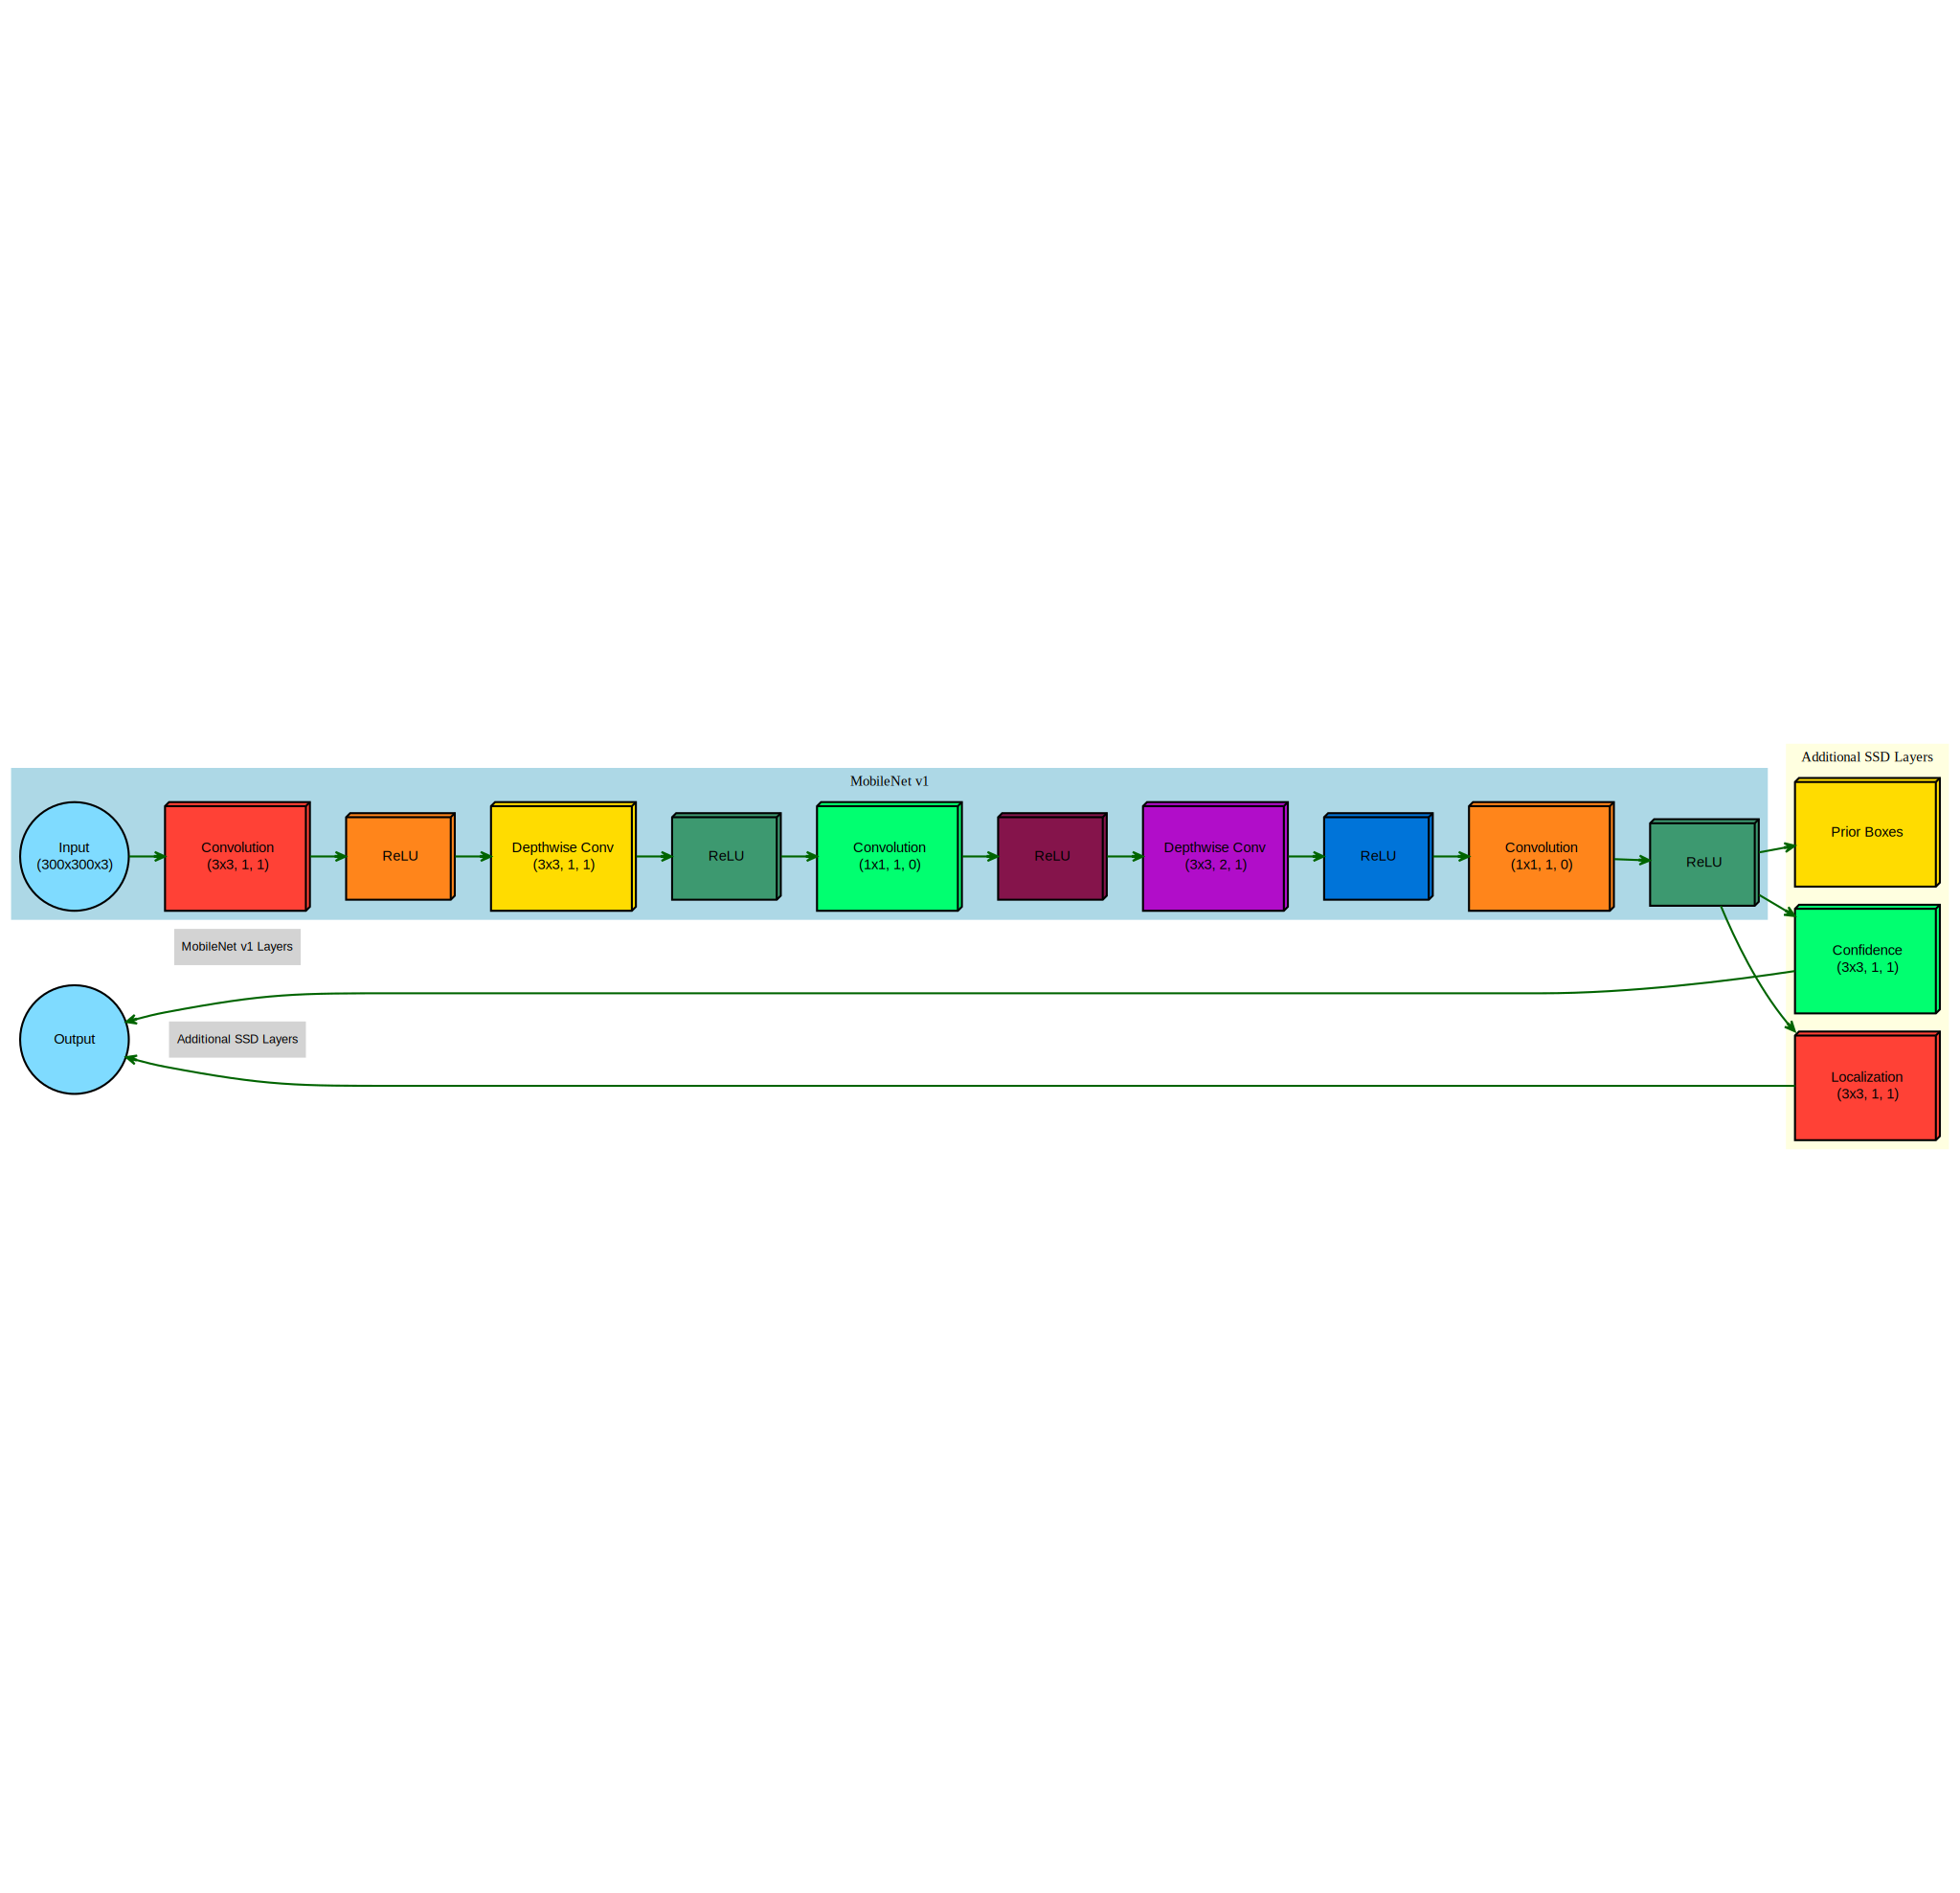

In [2]:
from IPython.display import SVG, display
from xml.dom import minidom

# Load the SVG file
svg_file = '/kaggle/input/machine-learning-architecture-diagrams/MobileNetV1_SSD.svg'
with open(svg_file, 'r') as file:
    svg_content = file.read()

# Remove the width and height attributes from the SVG element
dom = minidom.parseString(svg_content)
svg_element = dom.getElementsByTagName('svg')[0]
svg_element.removeAttribute('width')
svg_element.removeAttribute('height')
svg_content = dom.toxml()

# Modify the SVG content to scale the image
adjusted_svg_content = svg_content.replace('<svg', '<svg width="5800" height="5600"')

# Display the adjusted SVG content
display(SVG(data=adjusted_svg_content))


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Importing modules
    </div>

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, ZeroPadding2D,DepthwiseConv2D, ReLU, Input,AveragePooling2D, GlobalAveragePooling2D,Dense,Dropout
from tensorflow.keras.activations import sigmoid,relu
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential,Model
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import xml.etree.ElementTree as ET
import glob
import numpy as np
np.random.seed(42)
import cv2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Helper functions for parsing the xml content and getting annotation content    </div>

In [4]:
def FindNumberBoundingBoxes(root):
    index = 0
    while True:
        if GetInt('xmin', root, index) == -1:
              break
        index += 1
    return index

def GetInt(name, root, index=0):
      return int(GetItem(name, root, index))

def GetItem(name, root, index=0):
    count = 0
    for item in root.iter(name):
        if count == index:
            return item.text
        count += 1
       # Failed to find "index" occurrence of item.
    return -1

def process_xml(xmlfile):
    tree = ET.parse(xmlfile)
    root = tree.getroot()

    num_boxes = FindNumberBoundingBoxes(root)
    attributes = []

    for index in range(num_boxes):
        # Grab the 'index' annotation.
        xmin = GetInt('xmin', root, index)
        ymin = GetInt('ymin', root, index)
        xmax = GetInt('xmax', root, index)
        ymax = GetInt('ymax', root, index)

        width = GetInt('width', root)
        height = GetInt('height', root)
        filename = GetItem('filename', root) + '.JPEG'
        label = GetItem('name', root)
        
    attributes.append([[xmin,ymin,xmax,ymax],[width],[height],[filename],[label]])
    return attributes

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Declaring train and val path    </div>

In [5]:
train_path = "/kaggle/input/fruit-images-for-object-detection/train_zip/train/"
val_path = "/kaggle/input/fruit-images-for-object-detection/test_zip/test"

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Visualizing train dataset samples    </div>

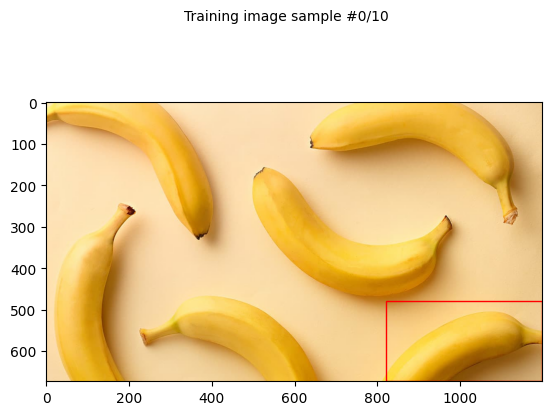

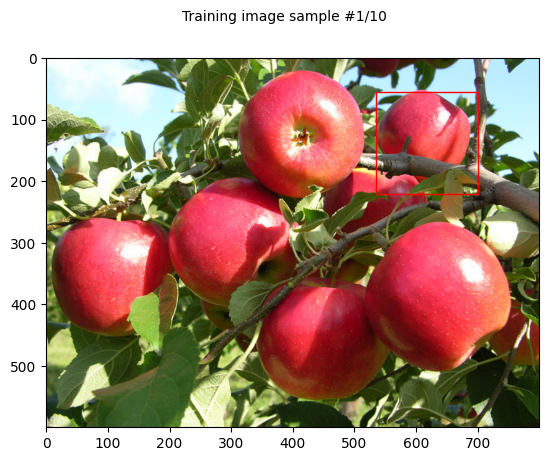

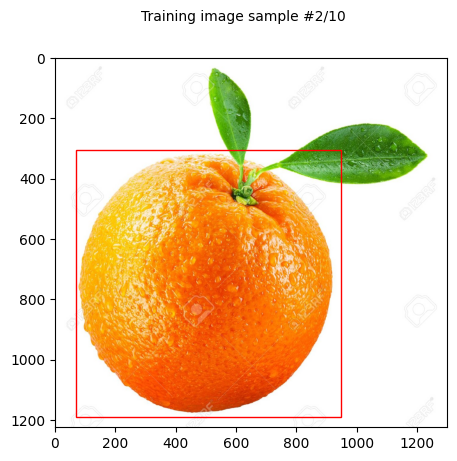

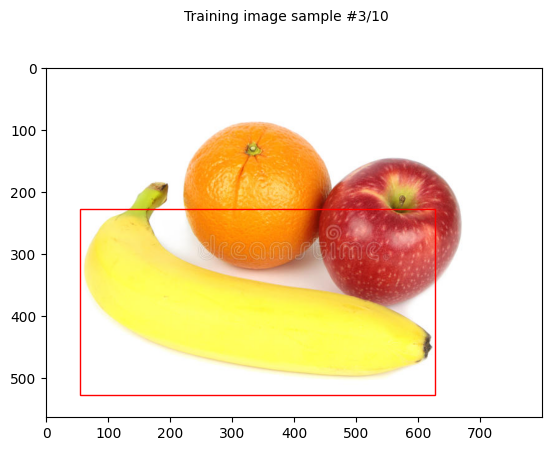

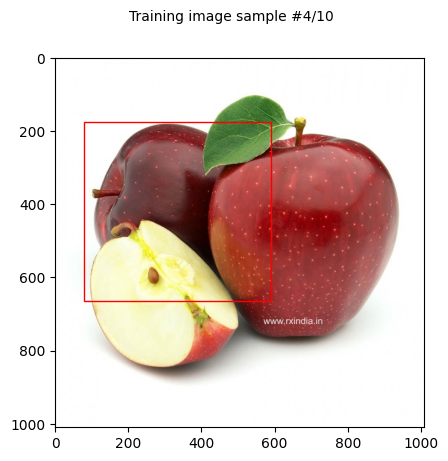

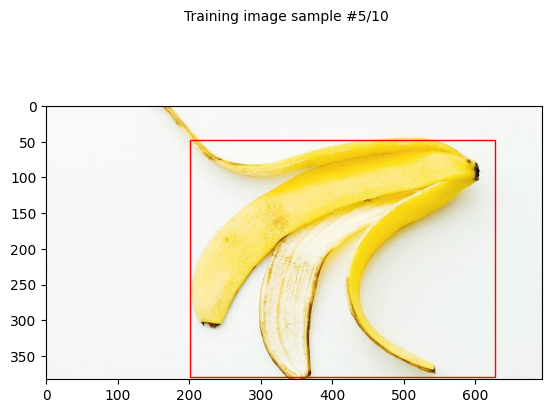

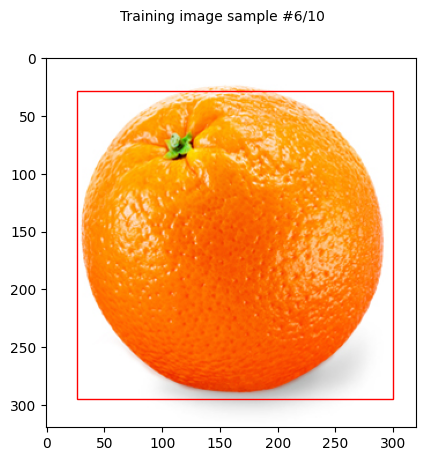

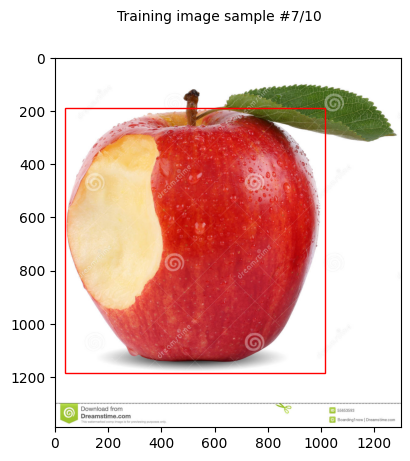

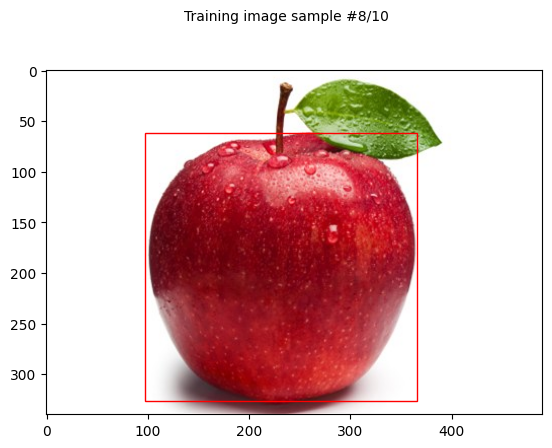

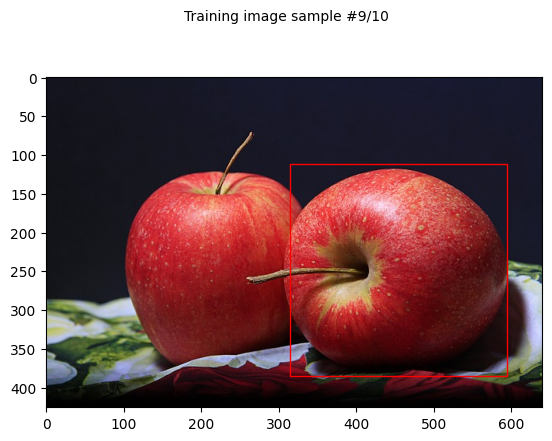

In [6]:

idx =0
for train_file, train_annotation in zip(glob.glob(train_path+"/*.jpg"),glob.glob(train_path+"/*.xml")):
    #displaying only first 10 images
    if idx<10:
        # Training image processing
        #reading image 
        train_image = Image.open(train_file)
        #reading bounding box xml file and processing to fetch xA,yA,xB,yB
        train_annotation = train_file.split('\\')[-1].split('.')[0]+".xml"
        train_content = process_xml(train_annotation)
        #print(train_content,train_image)
        xA,yA,xB,yB = train_content[0][0]
        #processing done
        fig,ax = plt.subplots()
        fig.suptitle("Training image sample #{}/10".format(idx), fontsize=10)

        ax.imshow(train_image)
        rect = patches.Rectangle((xA,yA),xB-xA,yB-yA, linewidth=1, edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        plt.show()
        idx+=1


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Visualizing val dataset samples    </div>

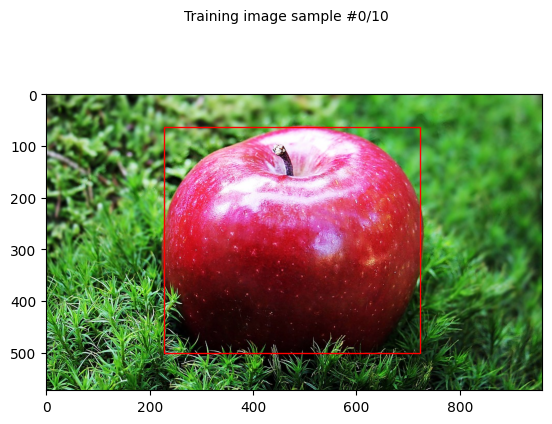

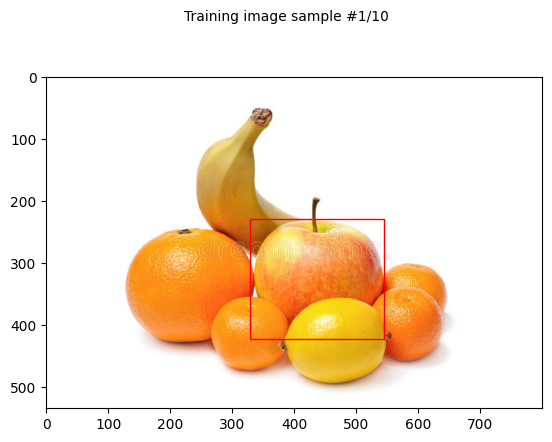

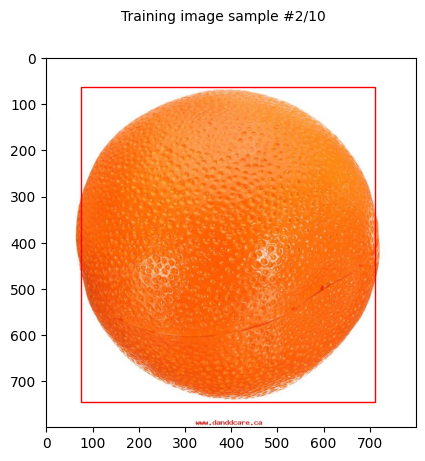

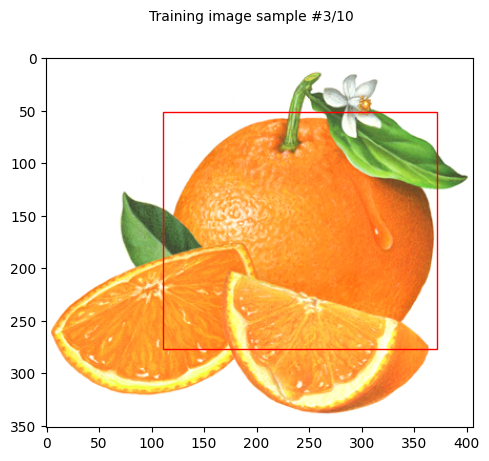

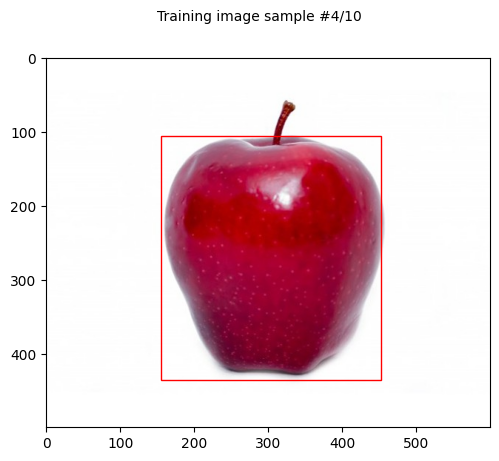

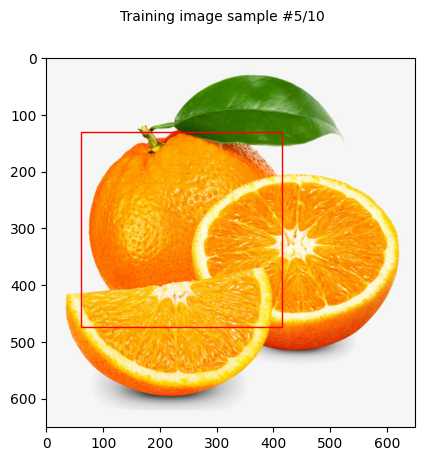

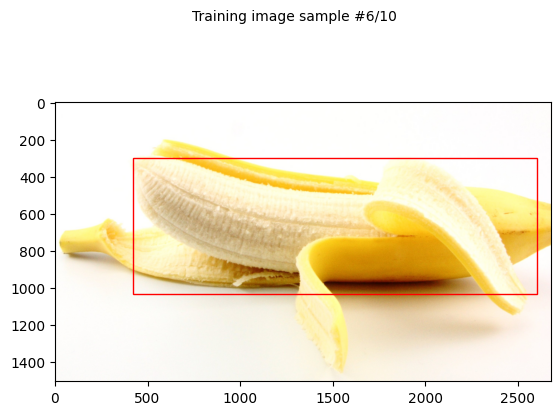

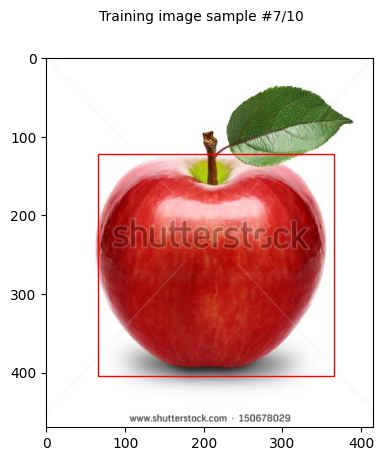

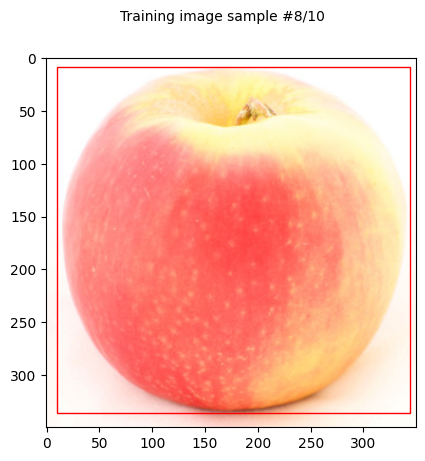

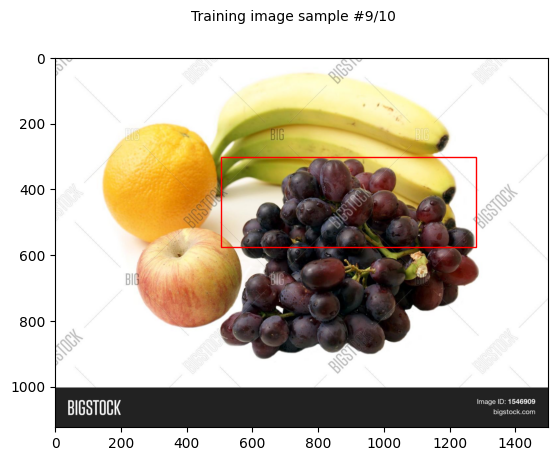

In [7]:
# Validation samples visualisation
idx =0
for val_file, val_annotation in zip(glob.glob(val_path+"/*.jpg"),glob.glob(val_path+"/*.xml")):
    #displaying only first 10 images
    if idx<10:
        # Val image processing
        #reading image 
        val_image = Image.open(val_file)
        #reading bounding box xml file and processing to fetch xA,yA,xB,yB
        val_annotation = val_file.split('\\')[-1].split('.')[0]+".xml"
        val_content = process_xml(val_annotation)
        #print(train_content,train_image)
        xA,yA,xB,yB = val_content[0][0]
        #processing done
        fig,ax = plt.subplots()
        fig.suptitle("Training image sample #{}/10".format(idx), fontsize=10)

        ax.imshow(val_image)
        rect = patches.Rectangle((xA,yA),xB-xA,yB-yA, linewidth=1, edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        plt.show()
        idx+=1


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Helper functions to normalize bounding box coordinates    </div>

In [8]:
#now creating 4 lists to store features and labels
LabelDict = {"apple":0,"banana":1, "orange":2}
train_features, train_coordinates, train_labels, val_features,val_coordinates, val_labels = [],[],[],[],[],[]
#creating list of train,val images and xml files
train_images = glob.glob(train_path+"/*.jpg")
val_images = glob.glob(val_path+"/*.jpg")
train_annotations = glob.glob(train_path+"/*.xml")
val_annotations = glob.glob(val_path+"/*.xml")

#helper function for preprocessing
def normalize_annotation(coordinates, original, resized=(150,150)):
    W,H = np.shape(original)[0], np.shape(original)[1]
    #print(coordinates)
    scale_W,scale_H = 224.0/float(W),224.0/float(H)
    coordinates[0],coordinates[2] = coordinates[0]*scale_W,coordinates[2]*scale_W
    coordinates[1],coordinates[3] = coordinates[1]*scale_H,coordinates[3]*scale_H
    #print(coordinates)
    return coordinates

In [9]:
print(train_images[0],val_images[0],train_annotations[0],val_annotations[0])

/kaggle/input/fruit-images-for-object-detection/train_zip/train/banana_68.jpg /kaggle/input/fruit-images-for-object-detection/test_zip/test/apple_91.jpg /kaggle/input/fruit-images-for-object-detection/train_zip/train/apple_28.xml /kaggle/input/fruit-images-for-object-detection/test_zip/test/banana_84.xml


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Processing train and val dataset i.e normalizing the coordinates as per reshaped image size    </div>

In [10]:
#processing train dataset
for idx1 in range(1,len(train_images)):
    for idx2 in range(1,len(train_annotations)):
        if train_images[idx1].split('\\')[-1].split('.')[0] == train_annotations[idx2].split('\\')[-1].split('.')[0] :
            #open image
            train_image_content = cv2.imread(train_images[idx1])
            #reshaping the image
            resized_image_content = cv2.resize(train_image_content,(224,224), interpolation = cv2.INTER_AREA)
            #fetching the label and bounding box
            label = process_xml(train_annotations[idx2])[0][-1][0]
            bounding_box = process_xml(train_annotations[idx2])[0][0]
            #normalising labels as per new size
            #original shape of image
            normalised_coordinates = normalize_annotation(bounding_box,train_image_content)
            #now appending the data to corresponding lists
            print("Processed {} out {} images".format(idx1,len(train_images)))
            train_features.append(np.asarray(resized_image_content))
            train_coordinates.append(normalised_coordinates)
            train_labels.append([LabelDict[label]])

Processed 1 out 240 images
Processed 2 out 240 images
Processed 3 out 240 images
Processed 4 out 240 images
Processed 5 out 240 images
Processed 6 out 240 images
Processed 7 out 240 images
Processed 8 out 240 images
Processed 9 out 240 images
Processed 10 out 240 images
Processed 11 out 240 images
Processed 12 out 240 images
Processed 13 out 240 images
Processed 14 out 240 images
Processed 15 out 240 images
Processed 16 out 240 images
Processed 17 out 240 images
Processed 18 out 240 images
Processed 19 out 240 images
Processed 20 out 240 images
Processed 21 out 240 images
Processed 22 out 240 images
Processed 23 out 240 images
Processed 24 out 240 images
Processed 25 out 240 images
Processed 26 out 240 images
Processed 27 out 240 images
Processed 28 out 240 images
Processed 29 out 240 images
Processed 30 out 240 images
Processed 31 out 240 images
Processed 32 out 240 images
Processed 33 out 240 images
Processed 34 out 240 images
Processed 35 out 240 images
Processed 36 out 240 images
P

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Processed 83 out 240 images
Processed 84 out 240 images
Processed 85 out 240 images
Processed 86 out 240 images
Processed 87 out 240 images
Processed 88 out 240 images
Processed 89 out 240 images
Processed 90 out 240 images
Processed 91 out 240 images
Processed 92 out 240 images
Processed 93 out 240 images
Processed 94 out 240 images
Processed 95 out 240 images
Processed 96 out 240 images
Processed 97 out 240 images
Processed 98 out 240 images
Processed 99 out 240 images
Processed 100 out 240 images
Processed 101 out 240 images
Processed 102 out 240 images
Processed 103 out 240 images
Processed 104 out 240 images
Processed 105 out 240 images
Processed 106 out 240 images
Processed 107 out 240 images
Processed 108 out 240 images
Processed 109 out 240 images
Processed 110 out 240 images
Processed 111 out 240 images
Processed 112 out 240 images
Processed 113 out 240 images
Processed 114 out 240 images
Processed 115 out 240 images
Processed 116 out 240 images
Processed 117 out 240 images
Pr

libpng warning: iCCP: known incorrect sRGB profile


Processed 201 out 240 images
Processed 202 out 240 images
Processed 203 out 240 images
Processed 204 out 240 images
Processed 205 out 240 images
Processed 206 out 240 images
Processed 207 out 240 images
Processed 208 out 240 images
Processed 209 out 240 images
Processed 210 out 240 images
Processed 211 out 240 images
Processed 212 out 240 images
Processed 213 out 240 images
Processed 214 out 240 images
Processed 215 out 240 images
Processed 216 out 240 images
Processed 217 out 240 images
Processed 218 out 240 images
Processed 219 out 240 images
Processed 220 out 240 images
Processed 221 out 240 images
Processed 222 out 240 images
Processed 223 out 240 images
Processed 224 out 240 images
Processed 225 out 240 images
Processed 226 out 240 images
Processed 227 out 240 images
Processed 228 out 240 images
Processed 229 out 240 images
Processed 230 out 240 images
Processed 231 out 240 images
Processed 233 out 240 images
Processed 234 out 240 images
Processed 235 out 240 images
Processed 236 

In [11]:
#processing val dataset
for idx1 in range(1,len(val_images)):
    for idx2 in range(1,len(val_annotations)):
        if val_images[idx1].split('\\')[-1].split('.')[0] == val_annotations[idx2].split('\\')[-1].split('.')[0] :
            #open image
            val_image_content = cv2.imread(val_images[idx1])
            #reshaping the image
            resized_image_content = cv2.resize(val_image_content,(224,224) ,interpolation = cv2.INTER_AREA)
            #fetching the label and bounding box
            label = process_xml(val_annotations[idx2])[0][-1][0]
            bounding_box = process_xml(val_annotations[idx2])[0][0]
            #normalising labels as per new size
            #original shape of image
            normalised_coordinates = normalize_annotation(bounding_box,val_image_content)
            #now appending the data to corresponding lists
            print("Processed {} out {} images".format(idx1,len(val_images)))
            val_features.append(np.asarray(resized_image_content))
            val_coordinates.append(normalised_coordinates)
            val_labels.append([LabelDict[label]])

Processed 1 out 60 images
Processed 2 out 60 images
Processed 3 out 60 images
Processed 4 out 60 images
Processed 5 out 60 images
Processed 6 out 60 images
Processed 7 out 60 images
Processed 8 out 60 images
Processed 9 out 60 images
Processed 10 out 60 images
Processed 11 out 60 images
Processed 12 out 60 images
Processed 13 out 60 images
Processed 14 out 60 images
Processed 15 out 60 images
Processed 16 out 60 images
Processed 17 out 60 images
Processed 18 out 60 images
Processed 19 out 60 images
Processed 20 out 60 images
Processed 21 out 60 images
Processed 22 out 60 images
Processed 23 out 60 images
Processed 24 out 60 images
Processed 25 out 60 images
Processed 26 out 60 images
Processed 27 out 60 images
Processed 28 out 60 images
Processed 30 out 60 images
Processed 31 out 60 images
Processed 32 out 60 images
Processed 33 out 60 images
Processed 34 out 60 images
Processed 35 out 60 images
Processed 36 out 60 images
Processed 37 out 60 images
Processed 38 out 60 images
Processed 

libpng warning: iCCP: known incorrect sRGB profile


Processed 54 out 60 images
Processed 55 out 60 images
Processed 56 out 60 images
Processed 57 out 60 images
Processed 58 out 60 images
Processed 59 out 60 images


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Converting each list to numpy array    </div>

In [12]:
train_features = np.asarray(train_features)
train_coordinates = np.asarray(train_coordinates)
#converting to one hot encoded
train_labels = tf.keras.utils.to_categorical(
    train_labels, num_classes=3, dtype='float32'
)

In [13]:
val_features = np.asarray(val_features)
val_coordinates = np.asarray(val_coordinates)
#converting to one hot_encoded
val_labels = tf.keras.utils.to_categorical(
    val_labels, num_classes=3, dtype='float32'
)

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Sanity check of the shapes of the dataset</div>

In [14]:
print("Shape of training features", np.shape(train_features))
print("Shape of training coordinates",np.shape(train_coordinates))
print("shape of training labels", np.shape(train_labels))

Shape of training features (238, 224, 224, 3)
Shape of training coordinates (238, 4)
shape of training labels (238, 3)


In [15]:
print("Shape of validation features", np.shape(val_features))
print("Shape of validation coordinates",np.shape(val_coordinates))
print("shape of validation labels", np.shape(val_labels))

Shape of validation features (58, 224, 224, 3)
Shape of validation coordinates (58, 4)
shape of validation labels (58, 3)


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Performing sanity check of the resized annotations    </div>

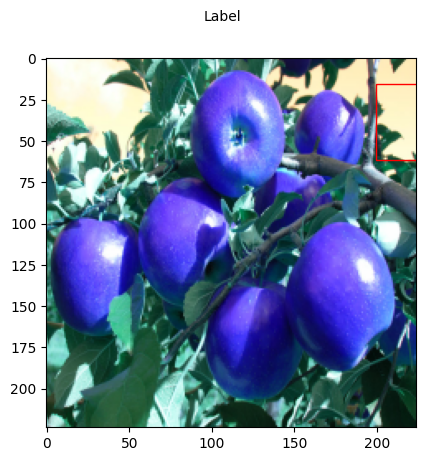

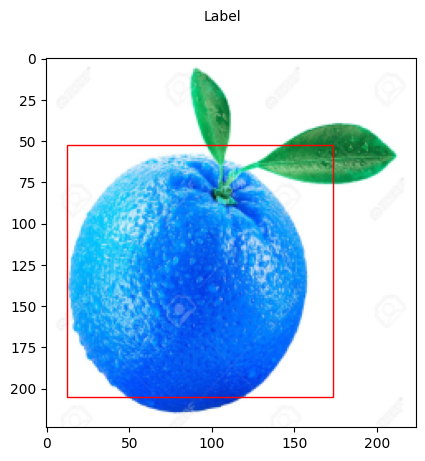

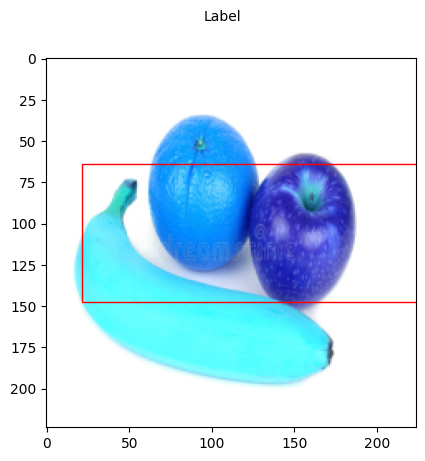

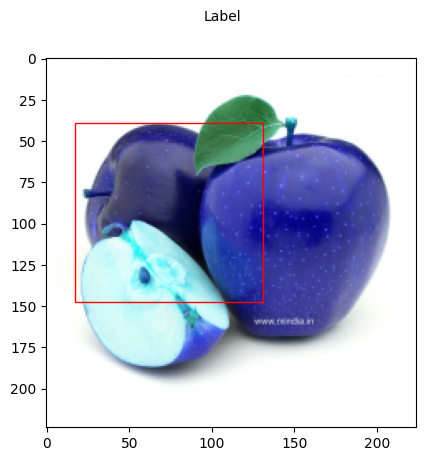

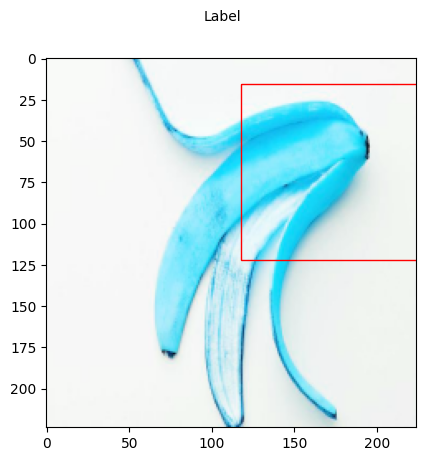

In [16]:
#validating the resized annotation by visualisation
for i in range(5):
  fig,ax = plt.subplots()
  fig.suptitle("Label".format(train_labels[i]), fontsize=10)
  ax.imshow(train_features[i])
  xA,yA,xB,yB = train_coordinates[i]
  rect = patches.Rectangle((xA,yA),xB-xA,yB-yA, linewidth=1, edgecolor='r',facecolor='none')
  ax.add_patch(rect)

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Defining MobileNet v1 ssd architecture    </div>

In [17]:
def MobileNetv1(input_shape, n_coor, number_classes):
   #depth wise convolution block definition
    def depthwise_convolutionBlock(InputTensor, pointwise_filter_size, stride):
    #Depthwise layer
        x = DepthwiseConv2D(3,stride,padding='same')(InputTensor)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        #Pointwise layer
        x = Conv2D(pointwise_filter_size,1)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        return x

    Model_input = Input(input_shape)
    x = Conv2D(32,3,2,padding='same')(Model_input)
    #Batch normalisation and ReLU activation after each convolution are mandatory for non-linearity and avoiding co-variance shift
    x = BatchNormalization()(x)
    x = ReLU()(x)
    print(x)
    #now stacking depthwise conv block as per Mobilenet paper
    x = depthwise_convolutionBlock(x,64,1)
    print(x)
    x = depthwise_convolutionBlock(x,128,2)
    x = Dropout(0.2)(x)
    x = depthwise_convolutionBlock(x,128,1)
    x = depthwise_convolutionBlock(x,256,2)
    x = Dropout(0.2)(x)
    x = depthwise_convolutionBlock(x,256,1)
    x = Dropout(0.2)(x)
    x = depthwise_convolutionBlock(x,512,2)
    for i in range(5):
        x = depthwise_convolutionBlock(x,512,1)
        x = depthwise_convolutionBlock(x,1024,1)
        x = depthwise_convolutionBlock(x,1024,1)
    #Adding average pooling 2D layer
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    #4 coordinates
    bbox_coordinates = Dense(4, activation = 'linear', name = 'regressor')(x)
    #x = GlobalAveragePooling2D()
    # full connected i.e dense layer
    logits = Dense(number_classes, activation='softmax', name='classifier')(x)
    
    model = Model(inputs = Model_input, outputs = [bbox_coordinates,logits])
    return model

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Initializing the model   </div>

In [18]:
Input_shape = 224,224,3
num_classes = 3
n_coor = 4
model = MobileNetv1(Input_shape,n_coor,num_classes)
model.summary()
#dense_6 is the output of regression:: bbox end
# dense_7 is the output of classification end

KerasTensor(type_spec=TensorSpec(shape=(None, 112, 112, 32), dtype=tf.float32, name=None), name='re_lu/Relu:0', description="created by layer 're_lu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 112, 112, 64), dtype=tf.float32, name=None), name='re_lu_2/Relu:0', description="created by layer 're_lu_2'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  896         ['input_1[0][0]']                
                                )                                                  

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Compiling the model    </div>

In [19]:
#compiling model with loss functions
init_lr = 0.0001
epochs = 100
opt = tf.keras.optimizers.legacy.Adam(lr=init_lr, decay=init_lr / epochs)
model.compile(optimizer=opt, 
              loss={'regressor':'mse','classifier':'categorical_crossentropy'}, 
              metrics={'regressor':'accuracy','classifier':'accuracy'})

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Training the model for 10 epochs    </div>

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint
#optional#callbacks = [ModelCheckpoint("/kaggle/input", monitor='val_loss')]
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(train_features,[train_coordinates,train_labels],batch_size = 4,epochs = 100,verbose=1, validation_data=(val_features, [val_coordinates,val_labels]),shuffle=True, validation_batch_size=32 ,use_multiprocessing=True,workers=12 )

Epoch 1/100


2023-09-22 03:11:41.604186: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


60/60 [==============================] - 5s 41ms/step - loss: 3440.9766 - regressor_loss: 3439.8201 - classifier_loss: 1.1575 - regressor_accuracy: 0.7521 - classifier_accuracy: 0.3403 - val_loss: 4572.1885 - val_regressor_loss: 4571.0552 - val_classifier_loss: 1.1336 - val_regressor_accuracy: 0.7069 - val_classifier_accuracy: 0.2931
Epoch 2/100
60/60 [==============================] - 2s 40ms/step - loss: 3043.5066 - regressor_loss: 3042.3726 - classifier_loss: 1.1335 - regressor_accuracy: 0.7521 - classifier_accuracy: 0.3866 - val_loss: 4645.0786 - val_regressor_loss: 4643.9067 - val_classifier_loss: 1.1722 - val_regressor_accuracy: 0.7069 - val_classifier_accuracy: 0.2241
Epoch 3/100
60/60 [==============================] - 2s 40ms/step - loss: 2875.3267 - regressor_loss: 2874.2029 - classifier_loss: 1.1236 - regressor_accuracy: 0.7521 - classifier_accuracy: 0.3992 - val_loss: 4471.0527 - val_regressor_loss: 4469.9092 - val_classifier_loss: 1.1440 - val_regressor_accuracy: 0.7069 - 

In [22]:
model.save("FruitDetector.h5")

/kaggle/input/fruit-images-for-object-detection/test_zip/test/apple_77.jpg
1/1 [==============================] - 1s 921ms/step


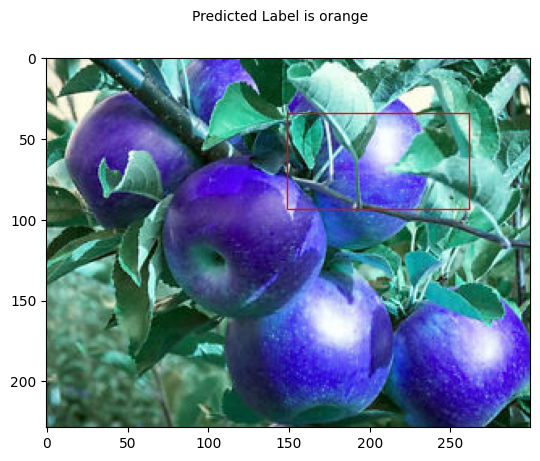

In [23]:
#prediction stage
image_list = []
image_list.append('/kaggle/input/fruit-images-for-object-detection/test_zip/test/apple_77.jpg')

for orig_image in image_list:
  print(orig_image)
  orig_image = cv2.imread(orig_image)
  image = cv2.resize(orig_image,(224,224),interpolation = cv2.INTER_AREA)
  image = np.reshape(image,(1,224,224,3))
  #np.shape(image))
  out_tensor = model.predict(image)
  #finding the class_label
  LabelDict = {0:"apple",1:"banana", 2:"orange"}
  class_label = LabelDict[np.argmax(out_tensor[1])]
  xA,yA,xB,yB= out_tensor[0][0]
  #visualising
  fig,ax = plt.subplots()
  fig.suptitle("Predicted Label is {}".format(class_label), fontsize=10)
  ax.imshow(orig_image)
  rect = patches.Rectangle((xA,yA),xB-xA,yB-yA, linewidth=1, edgecolor='r',facecolor='none')
  ax.add_patch(rect)